# 籌碼用隨機森林預測隔天漲跌

摘要：
用證交所盤後揭露的現貨買賣超 + 期交所的法人期貨部位  預測隔天台指期是紅K棒或黑K棒
想在這邊加**粗體**試試看

![](demo.jpg)

# 1.1 隨機森林 

資料集

```python
import numpy as np

```

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import matplotlib as matplot
plt.style.use('bmh')
import seaborn as sns
from tqdm import tqdm
import requests, datetime
from bs4 import BeautifulSoup


# nbn sdflasdf

In [11]:
df = pd.read_csv(
    "https://raw.githubusercontent.com/MaxChenCMC/csv_files_for_colab/master/txf_ohlc_backtest.csv",
    index_col="date",
    parse_dates=True,
).iloc[:, :11]
df.tail()


,inst_f buy,inst_t buy,inst_txf_net,inst_txf_oi,inst_mtx_net,inst_mtx_oi,tse_open,tse_high,tse_low,tse_close,tse_volume
date,,,,,,,,,,,
2021-09-06,7666042064,-1252559575,3523,-16296,734,4144,17534.05078,17633.66992,17461.07031,17495.30078,374194
2021-09-07,6690800894,-1488392384,715,-15580,-318,3822,17534.38086,17559.21094,17388.36914,17428.86914,335130
2021-09-08,-1072311064,-434523230,1383,-14197,-447,3366,17411.52930,17447.58008,17167.08008,17270.49023,321762
2021-09-09,-637610085,337589613,1043,-11655,-1457,-4087,17175.03906,17319.08984,17122.94922,17304.33008,244534
2021-09-10,14973318520,457382200,-2651,-14302,2767,-1336,17270.27930,17474.57031,17270.27930,17474.57031,265915


做多停損設20時，交易次數77，停利19次，被停損58次
放空停損設20時，交易次數71，停利23次，被停損48次
做多停損設25時，交易次數77，停利22次，被停損55次
放空停損設25時，交易次數71，停利25次，被停損46次
做多停損設30時，交易次數77，停利26次，被停損51次
放空停損設30時，交易次數71，停利29次，被停損42次
做多停損設35時，交易次數77，停利29次，被停損48次
放空停損設35時，交易次數71，停利31次，被停損40次
做多停損設40時，交易次數77，停利33次，被停損44次
放空停損設40時，交易次數71，停利36次，被停損35次
做多停損設45時，交易次數77，停利35次，被停損42次
放空停損設45時，交易次數71，停利37次，被停損34次
做多停損設50時，交易次數77，停利36次，被停損41次
放空停損設50時，交易次數71，停利39次，被停損32次
做多停損設55時，交易次數77，停利42次，被停損35次
放空停損設55時，交易次數71，停利41次，被停損30次
做多停損設60時，交易次數77，停利47次，被停損30次
放空停損設60時，交易次數71，停利44次，被停損27次
做多停損設65時，交易次數77，停利50次，被停損27次
放空停損設65時，交易次數71，停利46次，被停損25次
做多停損設70時，交易次數77，停利52次，被停損25次
放空停損設70時，交易次數71，停利50次，被停損21次
做多停損設75時，交易次數77，停利53次，被停損24次
放空停損設75時，交易次數71，停利51次，被停損20次
做多停損設80時，交易次數77，停利53次，被停損24次
放空停損設80時，交易次數71，停利52次，被停損19次
做多停損設85時，交易次數77，停利56次，被停損21次
放空停損設85時，交易次數71，停利52次，被停損19次
做多停損設90時，交易次數77，停利58次，被停損19次
放空停損設90時，交易次數71，停利54次，被停損17次
做多停損設95時，交易次數77，停利59次，被停損18次
放空停損設95時，交易次數71，停利54次，被停損17次
做多停損設100時，交易次數77，停利59次，被停損18次
放空停損設100時，交易次數71，停利57次，被停損14次


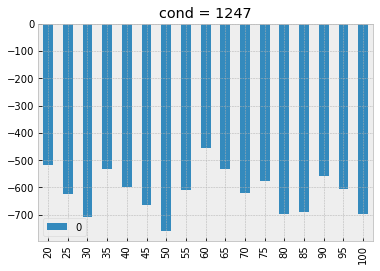

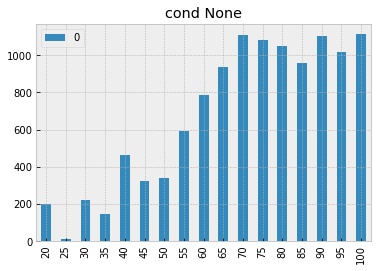

In [12]:
bull_tb, bear_tb = dict(), dict()
for threshold in range(20, 101, 5):
    df = pd.read_csv('https://raw.githubusercontent.com/MaxChenCMC/csv_files_for_colab/master/txf_ohlc_backtest.csv', index_col = 'date', parse_dates = True)
    cond1 = df['inst_f buy'] > df['inst_f buy'].rolling(5).mean()
    cond2 = df['inst_t buy'] > df['inst_t buy'].rolling(5).mean()
    cond3 = df['inst_txf_net'] > 0
    cond4 = df['inst_txf_oi'] > df['inst_txf_oi'].rolling(5).median()
    cond5 = df['inst_mtx_net'] > 0
    cond6 = (df['inst_mtx_oi'] > df['inst_mtx_oi'].rolling(5).median()) & (df['inst_mtx_oi'] > 0)
    cond7 = df['above_ma'] > df['above_ma'].rolling(5).mean()

    cond = df[4:-1][cond1[4:-1] & cond2[4:-1]& cond4[4:-1]& cond7[4:-1]
                    ].index

    cond_next = [df[df.index > cond[i]].index[0] for i in range(len(cond))]
    df1 = df[df.index.isin(cond_next)]

    fee = 4
    df1_sl = df1[(df1['txf_open'] - threshold > df1['txf_low'])] 
    sl = len(df1_sl) * (-threshold - fee) # 直接求出值了，不是LIST
    df1_tp = df1[~(df1['txf_open'] - threshold > df1['txf_low'])]    
    tp = df1_tp['txf_close'] - df1_tp['txf_open'] - fee
    print(f'做多停損設{threshold}時，交易次數{len(df1)}，停利{len(df1_tp)}次，被停損{len(df1_sl)}次')
    log_long = {threshold : [sum(tp) + sl]}
    bull_tb.update(log_long)

    cond = df[~(cond1 | cond2 | cond3 | cond4 | cond5 | cond6 | cond7)].index
    cond_next = [df[df.index > cond[i]].index[0] for i in range(len(cond))]
    df1 = df[df.index.isin(cond_next)]

    df1_sl = df1[(df1['txf_open'] + threshold < df1['txf_high'])] 
    sl = len(df1_sl) * (-threshold - 4)
    df1_tp = df1[~(df1['txf_open'] + threshold < df1['txf_high'])]
    tp = df1_tp['txf_open'] - df1_tp['txf_close'] - 4
    print(f'放空停損設{threshold}時，交易次數{len(df1)}，停利{len(df1_tp)}次，被停損{len(df1_sl)}次')
    log_short = {threshold : [sum(tp) + sl]}
    bear_tb.update(log_short)

pd.DataFrame(bull_tb.values(), index = bull_tb.keys()).plot(kind = 'bar', title = 'cond = 1247')
pd.DataFrame(bear_tb.values(), index = bear_tb.keys()).plot(kind = 'bar', title = 'cond None')